## 0. Required Libraries

In [64]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


import joblib
import json
import pandas as pd
import numpy as np
import copy
import hashlib

import src.util as util

## 1. Load Configuration File

In [65]:
params = util.load_config()

## 2. Load Dataset

In [66]:
def load_train_feng(params: dict) -> pd.DataFrame:
    # Load train set
    x_train = util.pickle_load(params["train_set_path"][0])
    y_train = util.pickle_load(params["train_set_path"][1])

    return x_train, y_train

def load_valid_feng(params: dict) -> pd.DataFrame:
    # Load valid set
    x_valid = util.pickle_load(params["valid_set_path"][0])
    y_valid = util.pickle_load(params["valid_set_path"][1])

    return x_valid, y_valid

def load_test_feng(params: dict) -> pd.DataFrame:
    # Load test set
    x_test = util.pickle_load(params["test_set_path"][0])
    y_test = util.pickle_load(params["test_set_path"][1])

    return x_test, y_test

In [67]:
def load_dataset(params: dict) -> pd.DataFrame:
    # Debug message
    util.print_debug("Loading dataset.")

    # Load train set
    x_train, y_train = load_train_feng(params)

    # Load valid set
    x_valid, y_valid = load_valid_feng(params)

    # Load test set
    x_test, y_test = load_test_feng(params)

    # Debug message
    util.print_debug("Dataset loaded.")

    # Return the dataset
    return x_train, y_train, x_valid, y_valid, x_test, y_test

## 3. Create Training Log Template

In [68]:
def training_log_template() -> dict:
    # Debug message
    util.print_debug("Creating training log template.")
    
    # Template of training log
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "mse" : [],
        "data_configurations" : [],
    }

    # Debug message
    util.print_debug("Training log template created.")

    # Return training log template
    return logger

In [69]:
def training_log_updater(current_log: dict, params: dict) -> list:
    # Create copy of current log
    current_log = copy.deepcopy(current_log)

    # Path for training log file
    log_path = params["training_log_path"]

    # Try to load training log file
    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()

    # If file not found, create a new one
    except FileNotFoundError as fe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()

        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    # Add current log to previous log
    last_log.append(current_log)

    # Save updated log
    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    # Return log
    return last_log

## 4. Training and Evaluation

### 4.1 Create Model Object

In [78]:
def create_model_object(params: dict) -> list:
    # Debug message
    util.print_debug("Creating model objects.")

    # Create model objects

    lnr = LinearRegression()
    #rdg = Ridge()
    #dct = DecisionTreeRegressor()
    #ran = RandomForestRegressor()
    #nn = KNeighborsRegressor()
    #xgb = XGBRegressor()
    srm = "SARIMAX_PLACEHOLDER"
   

    # Create list of model
    list_of_model = [
        { "model_name": lnr.__class__.__name__, "model_object": lnr, "model_uid": ""},
        
        { "model_name": "SARIMAX", "model_object": srm, "model_uid": ""}

    ]

    # Debug message
    util.print_debug("Model objects created.")

    # Return the list of model
    return list_of_model

### 4.2 Training Baseline Model

In [79]:
def train_eval(configuration_model: str, params: dict, hyperparams_model: list = None):
    # Load dataset
    x_train, y_train, \
    x_valid, y_valid, \
    x_test, y_test = load_dataset(params)

    # Variabel to store trained models
    list_of_trained_model = dict()

    # Create log template
    training_log = training_log_template()

    # Training for every data configuration
    for config_data in x_train.columns:
        # Debug message
        util.print_debug("Training model based on configuration data: {}".format(config_data))

        # Create model objects
        if hyperparams_model == None:
            list_of_model = create_model_object(params)
        else:
            list_of_model = copy.deepcopy(hyperparams_model)

        # Variabel to store trained model
        trained_model = list()

        # Load train data based on its configuration
        x_train_data = x_train[[config_data]]
        y_train_data = y_train

        # Train each model by current dataset configuration
        for model in list_of_model:
            # Debug message
            util.print_debug("Training model: {}".format(model["model_name"]))

            # Handle SARIMAX separately
            if model["model_name"] == "SARIMAX":
                # Define SARIMAX order and seasonal_order
                order = (1, 1, 1)
                seasonal_order = (1, 1, 1, 12)

                # Create the SARIMAX model
                model["model_object"] = SARIMAX(endog=y_train_data, exog=x_train_data, order=order, seasonal_order=seasonal_order)

                # Training
                training_time = util.time_stamp()
                model["model_object"] = model["model_object"].fit()
                training_time = (util.time_stamp() - training_time).total_seconds()

                # Evaluation
                start_position = len(y_train_data)
                end_position = start_position + len(y_valid) - 1
                y_predict = model["model_object"].get_prediction(start=start_position, end=end_position, exog=x_valid[[config_data]]).predicted_mean

                print("Length of y_valid:", len(y_valid))
                print("Length of y_predict:", len(y_predict))
                performance = mean_squared_error(y_valid, y_predict)
            else:
                # Training
                training_time = util.time_stamp()
                model["model_object"].fit(x_train_data, y_train_data)
                training_time = (util.time_stamp() - training_time).total_seconds()

                # Evaluation
                y_predict = model["model_object"].predict(x_valid[[config_data]])
                performance = mean_squared_error(y_valid, y_predict)

            # Debug message
            util.print_debug("Logging: {}".format(model["model_name"]))

            # Create UID
            uid = hashlib.md5(str(training_time).encode()).hexdigest()

            # Assign model's UID
            model["model_uid"] = uid

            # Create training log data
            training_log["model_name"].append("{}-{}".format(configuration_model, model["model_name"]))
            training_log["model_uid"].append(uid)
            training_log["training_time"].append(training_time)
            training_log["training_date"].append(util.time_stamp())
            training_log["performance"].append(performance)
            training_log["mse"].append(performance)
            training_log["data_configurations"].append('no configuration')

            # Collect current trained model
            trained_model.append(copy.deepcopy(model))

            # Debug message
            util.print_debug("Model {} has been trained for configuration data {}.".format(model["model_name"], config_data))

            
        # Collect current trained list of model
        list_of_trained_model[config_data] = copy.deepcopy(trained_model)
    
    # Debug message
    util.print_debug("All combination models and configuration data has been trained.")
    
    # Return list trained model
    return list_of_trained_model, training_log

In [80]:
list_of_trained_model, training_log = train_eval("Baseline", params)

2023-05-02 07:30:03.617039 Loading dataset.
2023-05-02 07:30:03.622008 Dataset loaded.
2023-05-02 07:30:03.622024 Creating training log template.
2023-05-02 07:30:03.622033 Training log template created.
2023-05-02 07:30:03.622081 Training model based on configuration data: ^JKII
2023-05-02 07:30:03.622085 Creating model objects.
2023-05-02 07:30:03.622141 Model objects created.
2023-05-02 07:30:03.623223 Training model: LinearRegression
2023-05-02 07:30:03.633463 Logging: LinearRegression
2023-05-02 07:30:03.634250 Model LinearRegression has been trained for configuration data ^JKII.
2023-05-02 07:30:03.634255 Training model: SARIMAX
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.18801D+00    |proj g|=  1.58867D+01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f= -2.28375D+00    |proj g|=  1.68548D-01

At iterate   10    f= -2.28965D+00    |proj g|=  7.05577D+00

At iterate   15    f= -2.34665D+00    |proj g|=  6.75065D-01

At iterate   20    f= -2.34719D+00    |proj g|=  1.29879D+00

At iterate   25    f= -2.38154D+00    |proj g|=  5.38994D+00

At iterate   30    f= -2.38642D+00    |proj g|=  3.17569D-02

At iterate   35    f= -2.41117D+00    |proj g|=  1.26066D+00

At iterate   40    f= -2.41706D+00    |proj g|=  3.04883D-01

At iterate   45    f= -2.41739D+00    |proj g|=  2.20361D-01


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it ha


At iterate   50    f= -2.41746D+00    |proj g|=  5.41270D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65      1     0     0   5.413D-01  -2.417D+00
  F =  -2.4174593902210475     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Length of y_valid: 32
Length of y_predict: 32
2023-05-02 07:30:05.705451 Logging: SARIMAX
2023-05-02 07:30:05.733267 Model SARIMAX has been trained for configuration data ^JKII.
2023-05-02 07:30:05.738926 Training model based on configuration data: ^JKLQ45
2023-05-02 07:30:05.738937 Creating model objects.
2023-05-02 07:30:05.738942 Model objects created.
202

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it ha


At iterate   50    f= -2.41909D+00    |proj g|=  7.86449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66      1     0     0   7.864D-03  -2.419D+00
  F =  -2.4190851504426232     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Length of y_valid: 32
Length of y_predict: 32
2023-05-02 07:30:07.000269 Logging: SARIMAX
2023-05-02 07:30:07.030192 Model SARIMAX has been trained for configuration data ^JKLQ45.
2023-05-02 07:30:07.047981 Training model based on configuration data: ^JKSE
2023-05-02 07:30:07.047994 Creating model objects.
2023-05-02 07:30:07.048000 Model objects created.
202

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### 4.3 Choose Best Performance Baseline Model

In [81]:
def get_production_model(list_of_model, training_log, params):
    # Create copy list of model
    list_of_model = copy.deepcopy(list_of_model)
    
    # Debug message
    util.print_debug("Choosing model by metrics score.")

    # Create required predefined variabel
    curr_production_model = None
    prev_production_model = None
    production_model_log = None

    # Debug message
    util.print_debug("Converting training log type of data from dict to dataframe.")

    # Convert dictionary to pandas for easy operation
    training_log = pd.DataFrame(copy.deepcopy(training_log))

    # Debug message
    util.print_debug("Trying to load previous production model.")

    # Check if there is a previous production model
    try:
        prev_production_model = util.pickle_load(params["production_model_path"])
        util.print_debug("Previous production model loaded.")

    except FileNotFoundError as fe:
        util.print_debug("No previous production model detected, choosing best model only from current trained model.")

    # If previous production model detected:
    if prev_production_model != None:
        # Debug message
        util.print_debug("Loading validation data.")
        x_valid, y_valid = load_valid_feng(params)
        
        # Debug message
        util.print_debug("Checking compatibilty previous production model's input with current train data's features.")

        # Check list features of previous production model and current dataset
        production_model_features = set(prev_production_model["model_data"]["model_object"].feature_names_in_)
        current_dataset_features = set(x_valid.columns)
        number_of_different_features = len((production_model_features - current_dataset_features) | (current_dataset_features - production_model_features))

        # If feature matched:
        if number_of_different_features == 0:
            # Debug message
            util.print_debug("Features compatible.")

            # Debug message
            util.print_debug("Reassesing previous model performance using current validation data.")

            # Re-predict previous production model to provide valid metrics compared to other current models
            y_pred = prev_production_model["model_data"]["model_object"].predict(x_valid)

            # Re-asses prediction result
            eval_res = mean_squared_error(y_valid, y_pred)

            # Debug message
            util.print_debug("Assessing complete.")

            # Debug message
            util.print_debug("Storing new metrics data to previous model structure.")

            # Update their performance log
            prev_production_model["model_log"]["performance"] = eval_res
            prev_production_model["model_log"]["mse"] = eval_res["mse"]

            # Debug message
            util.print_debug("Adding previous model data to current training log and list of model")

            # Added previous production model log to current logs to compere who has the greatest f1 score
            training_log = pd.concat([training_log, pd.DataFrame([prev_production_model["model_log"]])])

            # Added previous production model to current list of models to choose from if it has the greatest f1 score
            list_of_model["prev_production_model"] = [copy.deepcopy(prev_production_model["model_data"])]
        else:
            # To indicate that we are not using previous production model
            prev_production_model = None

            # Debug message
            util.print_debug("Different features between production model with current dataset is detected, ignoring production dataset.")

    # Debug message
    util.print_debug("Sorting training log by mse and training time.")

    # Sort training log by mse and training time
    best_model_log = training_log.sort_values(["mse", "training_time"], ascending = [False, True]).iloc[0]
    
    # Debug message
    util.print_debug("Searching model data based on sorted training log.")

    # Get model object with greatest mse score macro avg by using UID
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_log["model_uid"]:
                curr_production_model = dict()
                curr_production_model["model_data"] = copy.deepcopy(model_data)
                curr_production_model["model_log"] = copy.deepcopy(best_model_log.to_dict())
                curr_production_model["model_log"]["model_name"] = "Production-{}".format(curr_production_model["model_data"]["model_name"])
                curr_production_model["model_log"]["training_date"] = str(curr_production_model["model_log"]["training_date"])
                production_model_log = training_log_updater(curr_production_model["model_log"], params)
                break
    
    # In case UID not found
    if curr_production_model == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    # Debug message
    util.print_debug("Model chosen.")

    # Dump chosen production model
    util.pickle_dump(curr_production_model, params["production_model_path"])
    
    # Return current chosen production model, log of production models and current training log
    return curr_production_model, production_model_log, training_log
    

In [82]:
model, production_model_log, training_logs = get_production_model(list_of_trained_model, training_log, params)

2023-05-02 07:30:08.707103 Choosing model by metrics score.
2023-05-02 07:30:08.707223 Converting training log type of data from dict to dataframe.
2023-05-02 07:30:08.708453 Trying to load previous production model.
2023-05-02 07:30:08.754286 Previous production model loaded.
2023-05-02 07:30:08.754307 Loading validation data.
2023-05-02 07:30:08.754766 Checking compatibilty previous production model's input with current train data's features.


AttributeError: 'SARIMAXResults' object has no attribute 'feature_names_in_'

## 5. Hyperparameter Tuning

In [ ]:
def create_grid_params(model_name: str) -> dict:

    # Define models parameters
    grid_params_xgb = {
        "n_estimators": [50, 100, 200, 300, 400, 500]
    }
    grid_params_dct = {
        "criterion": ["squared_error", "friedman_mse", "absolute_error"],
        "min_samples_split": [1, 2, 4, 6, 10, 15, 20, 25],
        "min_samples_leaf": [1, 2, 4, 6, 10, 15, 20, 25]
    }
    grid_params_knn = {
        "weights": ["uniform", "distance"],
        "algorithm": ["ball_tree", "kd_tree", "brute"],
        "n_neighbors": [2, 3, 4, 5, 6, 10, 15, 20, 25],
        "leaf_size": [2, 3, 4, 5, 6, 10, 15, 20, 25],
        "metric": ["manhattan", "chebyshev"]
    }
    grid_params_ridge = {
        "alpha": [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.6, 0.9, 1],
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"],
    }
    grid_params_rfr = {
        "n_estimators": [50, 100, 200, 300, 400, 500],
        "criterion": ["mse", "mae"],
        "min_samples_split": [1, 2, 4, 6, 10, 15, 20, 25],
        "min_samples_leaf": [1, 2, 4, 6, 10, 15, 20, 25]
    }

    # Combine all models parameters into one
    grid_params = {
        "XGBRegressor": grid_params_xgb,
        "DecisionTreeRegressor": grid_params_dct,
        "KNeighborsRegressor": grid_params_knn,
        "Ridge": grid_params_ridge,
        "RandomForestRegressor": grid_params_rfr
    }

    # Return distribution of model parameters
    return grid_params[model_name]

In [ ]:
from sklearn.model_selection import GridSearchCV

def hyper_params_tuning(model: dict) -> list:
    # Create copy of current best baseline model
    model = copy.deepcopy(model)

    # Create model's parameter distribution
    grid_params = create_grid_params(model["model_data"]["model_name"])

    # Create model object
    model_gsc = GridSearchCV(model["model_data"]["model_object"], grid_params, n_jobs = -1)
    model_data = {
        "model_name": model["model_data"]["model_name"],
        "model_object": model_gsc,
        "model_uid": ""
    }
    
    # Return model object
    return [model_data]



In [ ]:
list_of_trained_model, training_log = train_eval("Hyperparams_Tuning", params, hyper_params_tuning(model))

KeyError: 'SARIMAX'

## 6. Take a Look at MSE & Prediction Plot

Mean Squared Error: 0.0004707348006435089


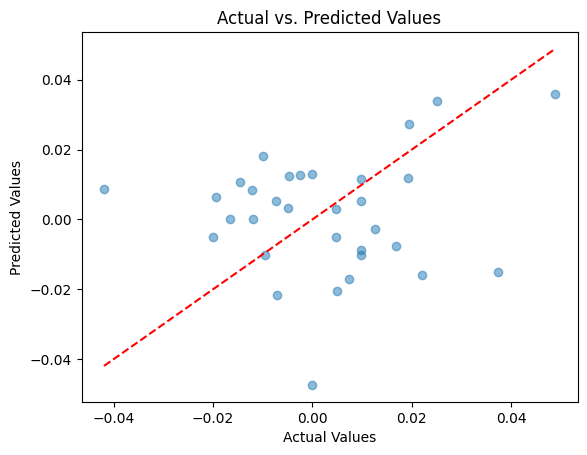

In [ ]:
import matplotlib.pyplot as plt

# Load data
x_train, y_train = load_train_feng(params)
x_valid, y_valid = load_valid_feng(params)
x_test, y_test = load_test_feng(params)


# Fit the model on the training set
model["model_data"]["model_object"].fit(x_train, y_train)

# Make predictions on the validation set
y_pred = model["model_data"]["model_object"].predict(x_valid)

# Calculate Mean Squared Error
mse = mean_squared_error(y_valid, y_pred)
print("Mean Squared Error:", mse)

# Scatter plot of actual vs. predicted values
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line representing a perfect prediction
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()
